In [1]:
import numpy as np
import pandas as pd
import os,sys
import datetime 
from datetime import timedelta
import matplotlib.pyplot as plt  ### We are going to plot the results in this notebook
from matplotlib.animation import FuncAnimation
import matplotlib.animation as animation
import matplotlib
import numpy as np
%matplotlib nbagg
import random

from Functions_for_animations import indices,compute_derivative,id_names_txt,avaliable_stations_vel,derivative


2025-01-06 20:11:38.561813: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-06 20:11:38.627061: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-06 20:11:39.055436: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/giacomo/anaconda3/envs/tff/lib/
2025-01-06 20:11:39.055476: W tensorflow/compile

Enter the root directory folder: /home/giacomo/Documents/
Directory found: /home/giacomo/Documents/Daily_GNSS_DL_Denoiser-main/sharing_gratsid_tf_in_development
Directory found: /home/giacomo/Documents/OLD/Denoiser_GPS/sharing_gratsid_tf_in_development
Num GPUs Available:  0
TensorFlow has access to the following devices:
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


2025-01-06 20:11:56.674276: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2025-01-06 20:11:56.674297: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: giacomo-Z590-AORUS-MASTER
2025-01-06 20:11:56.674302: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: giacomo-Z590-AORUS-MASTER
2025-01-06 20:11:56.674339: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 535.183.1
2025-01-06 20:11:56.674351: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 535.183.1
2025-01-06 20:11:56.674353: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 535.183.1


In [6]:
cd='/home/giacomo/Documents/OLD/Denoiser_GPS/Wordwide_dataset/'

############## I falsify latitude e longitude of the stations with exactly the same location ##############
df = pd.read_csv(cd+'Stations_coordinates.txt', delimiter=',',names=['station','latitude','longitude','height'],header=None)
latitude=list(df.latitude)
longitude=list(df.longitude)

duplicates_longitudes=dict((x, indices(longitude, x)) for x in set(longitude) if longitude.count(x) > 1) # Find  
for i in list(duplicates_longitudes.values()):
    longitude[i[1]]=longitude[i[1]]+0.00001

duplicates_latitudes=dict((x, indices(latitude, x)) for x in set(latitude) if latitude.count(x) > 1)
for i in list(duplicates_latitudes.values()):
    latitude[i[1]]=latitude[i[1]]+0.00001

df.latitude=latitude
df.longitude=longitude
print('Imported')

Imported


In [7]:
t = np.arange(datetime.datetime(2015,1,1), datetime.datetime(2023,1,1), datetime.timedelta(days=1)).astype(datetime.datetime)

In [8]:
componentsT=['E','N','U'] 
#### Choose components ####
indC=[0,1] #,2
components=list(np.array(componentsT)[indC])
print('You are using these components: ',np.array(componentsT)[indC])
gratsid_flag=True
exp_flag=True


namesT=[]
if gratsid_flag==True and exp_flag==True:
    for c in components:
        namesT.append([c,'DL_'+c,'EMV_'+c,'GrAtSiD_'+c])
else:
    for c in components:
        namesT.append([c,'DL_'+c])
names = [item for sublist in namesT for item in sublist]
names = ['YYMMDD'] + names
print(names)


You are using these components:  ['E' 'N']
['YYMMDD', 'E', 'DL_E', 'EMV_E', 'GrAtSiD_E', 'N', 'DL_N', 'EMV_N', 'GrAtSiD_N']


In [11]:
cd='/home/giacomo/Documents/OLD/Denoiser_GPS/New_zeland/'
input_length=31
to_end=2
position=input_length-to_end
step=1

soln_folder_path=cd+'Filtered_'+str(input_length)+'_'+str(position)
vel_folder=soln_folder_path+'_vel_'+str(step)+'d'

if not os.path.exists(vel_folder):
    os.makedirs(vel_folder)
    print(vel_folder," created successfully")
    compute_derivative(soln_folder_path,step,names,vel_folder)
    print(vel_folder," Derivative computed successfully")
else:
    print(vel_folder," already exists")

/home/giacomo/Documents/OLD/Denoiser_GPS/New_zeland/Filtered_31_29_vel_1d  already exists


<IPython.core.display.Javascript object>


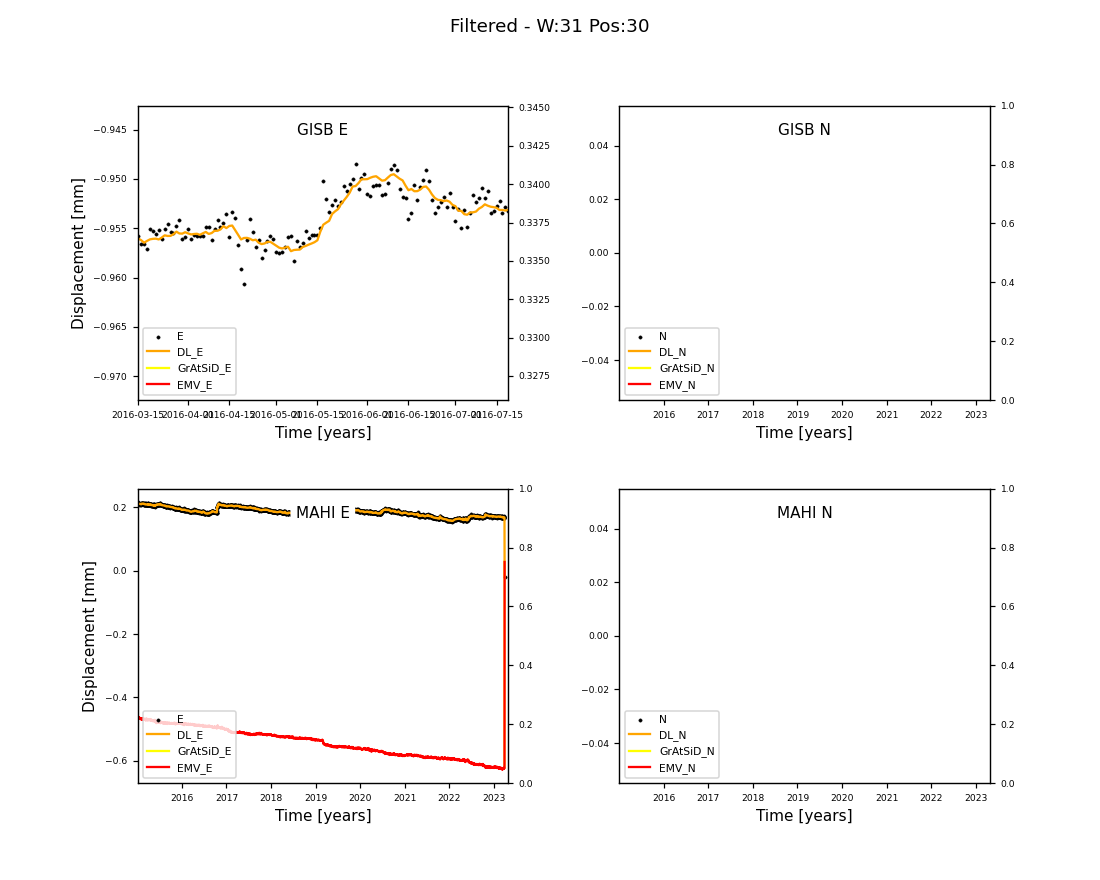

In [17]:

list_stations=id_names_txt(soln_folder_path)
n_stations=2
stations_to_plot=random.sample(list_stations,n_stations)

stations_to_plot[0]='GISB' #
stations_to_plot[1]='MAHI'
fig,ax=plt.subplots(n_stations,len(components),figsize=(10,8))
fig.subplots_adjust(hspace=0.3,wspace=0.3)
fig.suptitle('Filtered - W:'+str(input_length)+' Pos:'+str(position+1))

for i in range(n_stations):
    station=stations_to_plot[i]
    df_Filterd = pd.read_csv(soln_folder_path+'/'+station+'.txt', delim_whitespace=True,header=None,on_bad_lines='skip',names=names)
    df_Filterd['YYMMDD']= pd.to_datetime(df_Filterd['YYMMDD']).astype('datetime64[ns]')
    df_Filterd['YYMMDD'] = pd.to_datetime(df_Filterd["YYMMDD"]) 
    #df_Filterdvel = pd.read_csv(vel_folder+'/'+station+'.txt', delim_whitespace=True,header=None,on_bad_lines='skip',names=names)
    #df_Filterdvel['YYMMDD']= pd.to_datetime(df_Filterd['YYMMDD']).astype('datetime64[ns]')
    #df_Filterdvel['YYMMDD'] = pd.to_datetime(df_Filterd["YYMMDD"]) 
    for c in range(len(components)):
        ax[i,c].scatter(df_Filterd.YYMMDD,df_Filterd[components[c]],s=5,color='k',linewidth=0.2,label=components[c])
        ax[i,c].plot(df_Filterd.YYMMDD,df_Filterd['DL_'+components[c]],label='DL_'+components[c],color='orange')
        ax[i,c].plot(df_Filterd.YYMMDD,df_Filterd['GrAtSiD_'+components[c]],label='GrAtSiD_'+components[c],color='yellow')
        ax[i,c].plot(df_Filterd.YYMMDD,df_Filterd['EMV_'+components[c]],label='EMV_'+components[c],color='red')
        ax[i,c].set_xlim(df_Filterd.YYMMDD.iloc[0],df_Filterd.YYMMDD.iloc[-1])

        ax[i,c].set_xlabel('Time [years]')
        axo=ax[i,c].twinx()
        #axo.plot(df_Filterdvel.YYMMDD,df_Filterdvel['DL_'+components[c]],label='DL_'+components[c],color='orange',alpha=0.5)
        #axo.plot(df_Filterdvel.YYMMDD,df_Filterdvel['GrAtSiD_'+components[c]],label='GrAtSiD_'+components[c],color='yellow')
        #axo.plot(df_Filterdvel.YYMMDD,df_Filterdvel['EMV_'+components[c]],label='EMV_'+components[c],color='red',alpha=0.5)

        ax[i,c].legend(loc='lower left',fontsize=7)
        ax[i,c].text(.5,.9,str(station)+' '+components[c],horizontalalignment='center',
                 transform=ax[i,c].transAxes,fontsize=10,\
                 bbox=dict(facecolor='white', edgecolor='w',boxstyle='round'))
               
        ax[i,c].tick_params(axis='x', labelsize=6)
        ax[i,c].set_xlabel('Time [years]')
        ax[i,c].tick_params(axis='y', labelsize=6)
        if c==0:
            ax[i,c].set_ylabel('Displacement [mm]') 
        axo.tick_params(axis='y', labelsize=6)
plt.show()
   

In [14]:
vel_folder

'/home/giacomo/Documents/OLD/Denoiser_GPS/New_zeland/Filtered_31_29_vel_1d'